In [1]:
#My dependencies
import requests
import pandas as pd
from census import Census
from api_keys_JT import census_api_key
import matplotlib.pyplot as plt
import numpy as np

In [112]:
# Instance of the Census library
c = Census(census_api_key)

# Define the range of years you want to retrieve data for
years = range(2005, 2023)

# Initialize an empty list to store the data for each year
all_data = []

# Loop through each year and make the API call, add the year to each row.

for year in years:

	data = c.acs1.get(
		(
		'NAME',
		'B25077_001E',
		'B25058_001E',
		'B15003_022E',
		'B01003_001E',
		'B23025_004E',
		'B17001_002E',
		'B23025_003E'
		),
		{'for': 'county:*', 'in': 'state:*'},
	)

	for row in data:
		row['Year'] = year
		all_data.append(row)
	
#Making a DataFrame
data_df = pd.DataFrame(all_data)

data_df = data_df.rename(columns={
	'NAME': 'County Name',
	'state': 'State FIPS',
	'county': 'County FIPS',
	'B25077_001E': 'Median House Price ($)',
	'B25058_001E': 'Median Rent ($)',
	'B01003_001E': 'Total Population',
	'B15003_022E': 'Population with Bachelor\'s Degree',
	'B23025_004E':"Number of Employed People",
	'B17001_002E':"People with Income Below Poverty",
	'B23025_003E': "Total Labor Force"
})

# Display the first few rows of the DataFrame
data_df


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,State FIPS,County FIPS,Year
0,"Baldwin County, Alabama",304600.0,892.0,36327.0,246435.0,112931.0,32313.0,116464.0,01,003,2005
1,"Calhoun County, Alabama",148100.0,505.0,11551.0,115788.0,49681.0,20450.0,53066.0,01,015,2005
2,"Cullman County, Alabama",184800.0,501.0,8236.0,90665.0,40812.0,16019.0,43353.0,01,043,2005
3,"DeKalb County, Alabama",157700.0,437.0,3749.0,71998.0,31392.0,13967.0,32516.0,01,049,2005
4,"Elmore County, Alabama",204700.0,796.0,8481.0,89563.0,42508.0,9133.0,44198.0,01,051,2005
...,...,...,...,...,...,...,...,...,...,...,...
15259,"Ponce Municipio, Puerto Rico",95000.0,418.0,19333.0,132138.0,37696.0,68118.0,42956.0,72,113,2022
15260,"San Juan Municipio, Puerto Rico",164900.0,436.0,68930.0,334776.0,137999.0,126728.0,153027.0,72,127,2022
15261,"Toa Alta Municipio, Puerto Rico",174400.0,437.0,11355.0,66041.0,28504.0,18491.0,31453.0,72,135,2022
15262,"Toa Baja Municipio, Puerto Rico",138800.0,430.0,11652.0,72783.0,32493.0,24484.0,35481.0,72,137,2022


In [ ]:
# # Instance of the Census library
# c = Census(census_api_key)

# # Run Census Search to retrieve data on all counties (ACS5 Census Data)

# # Define the range of years you want to retrieve data for
# years = range(2005, 2023)

# # Initialize an empty list to store the data for each year
# all_data = []

# # Loop through each year and make the API call, add the year to each row.

# for year in years:

# 	data = c.acs5.get(
# 		(
# 		'NAME',
# 		'B25077_001E',
# 		'B25058_001E',
# 		'B15003_022E',
# 		'B01003_001E',
# 		'B23025_004E',
# 		'B17001_002E',
# 		'B23025_003E'
# 		),
# 		{'for': 'county:*', 'in': 'state:*'},
# 	)
	
# 	for row in data:
# 		row['Year'] = year
# 		all_data.append(row)
# 	print(len(all_data))
# #Making a DataFrame
# # data_df = pd.DataFrame(all_data)
# # data_df.head()

# data_df = data_df.rename(columns={
# 	'NAME': 'County Name',
# 	'state': 'State FIPS',
# 	'county': 'County FIPS',
# 	'B25077_001E': 'Median House Price ($)',
# 	'B25058_001E': 'Median Rent ($)',
# 	'B01003_001E': 'Total Population',
# 	'B15003_022E': 'Population with Bachelor\'s Degree',
# 	'B23025_004E':"Number of Employed People",
# 	'B17001_002E':"People with Income Below Poverty",
# 	'B23025_003E': "Total Labor Force"
# })

# # Display the first few rows of the DataFrame
# data_df.head()



3222
6444
9666
12888
16110
19332
22554
25776
28998
32220
35442
38664
41886
45108
48330
51552
54774
57996


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,State FIPS,County FIPS,Year
0,"Baldwin County, Alabama",304600.0,892.0,36327.0,246435.0,112931.0,32313.0,116464.0,01,003,2010
1,"Calhoun County, Alabama",148100.0,505.0,11551.0,115788.0,49681.0,20450.0,53066.0,01,015,2010
2,"Cullman County, Alabama",184800.0,501.0,8236.0,90665.0,40812.0,16019.0,43353.0,01,043,2010
3,"DeKalb County, Alabama",157700.0,437.0,3749.0,71998.0,31392.0,13967.0,32516.0,01,049,2010
4,"Elmore County, Alabama",204700.0,796.0,8481.0,89563.0,42508.0,9133.0,44198.0,01,051,2010


In [113]:
#check for missing values and check data types
print('Number of Null Values in Each Column:')
print(data_df.isnull().sum())
print('---------------------------------------------------')
# print(data_df.dtypes)

#There's 104 null values within Pop with Bachelors. We should remove these in the next step.

#Print Min and Max values to see how the data looks like and identify any negative values that need to be reviewed and/or removed.

print('Minimum Values:')
print(data_df.min())
print('---------------------------------------------------')
print('Maximum Values:')
print(data_df.max())


Number of Null Values in Each Column:
County Name                            0
Median House Price ($)                 0
Median Rent ($)                        0
Population with Bachelor's Degree    144
Total Population                       0
Number of Employed People              0
People with Income Below Poverty       0
Total Labor Force                      0
State FIPS                             0
County FIPS                            0
Year                                   0
dtype: int64
---------------------------------------------------
Minimum Values:
County Name                          Ada County, Idaho
Median House Price ($)                         66900.0
Median Rent ($)                                  375.0
Population with Bachelor's Degree               2911.0
Total Population                               64246.0
Number of Employed People                      19976.0
People with Income Below Poverty                1819.0
Total Labor Force                            

In [ ]:
#Find and remove any potential negative home/rent prices and remove NaN values.

clean_data_df = data_df[
    (data_df['Median House Price ($)'] > 0) &
    (data_df['Median Rent ($)'] > 0) &
    (data_df['Population with Bachelor\'s Degree'].notna())
]

print(clean_data_df.isnull().sum())

County Name                          0
Median House Price ($)               0
Median Rent ($)                      0
Population with Bachelor's Degree    0
Total Population                     0
Number of Employed People            0
People with Income Below Poverty     0
Total Labor Force                    0
State FIPS                           0
County FIPS                          0
Year                                 0
dtype: int64


In [62]:
#Series math to find variables(% of people in poverty, for example, rent-to-price) and add to the DF

clean_data_df['% Pop. Bachelors Degree'] = clean_data_df['Population with Bachelor\'s Degree'] / clean_data_df['Total Population'] * 100
clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
clean_data_df['% People Living in Poverty'] = (clean_data_df['People with Income Below Poverty'] / clean_data_df['Total Population']) * 100

clean_data_df

C:\Users\jitra\AppData\Local\Temp\ipykernel_2056\1803424263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['% Pop. Bachelors Degree'] = clean_data_df['Population with Bachelor\'s Degree'] / clean_data_df['Total Population'] * 100
C:\Users\jitra\AppData\Local\Temp\ipykernel_2056\1803424263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
C:\Users\jitra\A

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,State FIPS,County FIPS,Year,% Pop. Bachelors Degree,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty
0,"Baldwin County, Alabama",304600.0,892.0,36327.0,246435.0,112931.0,32313.0,116464.0,01,003,2005,14.741007,3.514117,96.966445,13.112180
1,"Calhoun County, Alabama",148100.0,505.0,11551.0,115788.0,49681.0,20450.0,53066.0,01,015,2005,9.975991,4.091830,93.621151,17.661588
2,"Cullman County, Alabama",184800.0,501.0,8236.0,90665.0,40812.0,16019.0,43353.0,01,043,2005,9.083991,3.253247,94.138814,17.668339
3,"DeKalb County, Alabama",157700.0,437.0,3749.0,71998.0,31392.0,13967.0,32516.0,01,049,2005,5.207089,3.325301,96.543240,19.399150
4,"Elmore County, Alabama",204700.0,796.0,8481.0,89563.0,42508.0,9133.0,44198.0,01,051,2005,9.469312,4.666341,96.176298,10.197291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15258,"Mayagüez Municipio, Puerto Rico",100200.0,380.0,8698.0,70609.0,20753.0,35272.0,26493.0,72,097,2022,12.318543,4.550898,78.333900,49.953972
15259,"Ponce Municipio, Puerto Rico",95000.0,418.0,19333.0,132138.0,37696.0,68118.0,42956.0,72,113,2022,14.630916,5.280000,87.754912,51.550652
15260,"San Juan Municipio, Puerto Rico",164900.0,436.0,68930.0,334776.0,137999.0,126728.0,153027.0,72,127,2022,20.589887,3.172832,90.179511,37.854565
15261,"Toa Alta Municipio, Puerto Rico",174400.0,437.0,11355.0,66041.0,28504.0,18491.0,31453.0,72,135,2022,17.193864,3.006881,90.624106,27.999273


In [74]:
#GROUPING ALL DATA BY COUNTIES
#To ensure exact matches, we need to group by all State FIPS, County FIPS, and County Name.
#This is because countys in different states may have the same name.
clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']

grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS'])
grouped_df.head()



C:\Users\jitra\AppData\Local\Temp\ipykernel_2056\362565594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,State FIPS,County FIPS,Year,% Pop. Bachelors Degree,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,Combined FIPS
0,"Baldwin County, Alabama",304600.0,892.0,36327.0,246435.0,112931.0,32313.0,116464.0,01,003,2005,14.741007,3.514117,96.966445,13.112180,00301
1,"Calhoun County, Alabama",148100.0,505.0,11551.0,115788.0,49681.0,20450.0,53066.0,01,015,2005,9.975991,4.091830,93.621151,17.661588,01501
2,"Cullman County, Alabama",184800.0,501.0,8236.0,90665.0,40812.0,16019.0,43353.0,01,043,2005,9.083991,3.253247,94.138814,17.668339,04301
3,"DeKalb County, Alabama",157700.0,437.0,3749.0,71998.0,31392.0,13967.0,32516.0,01,049,2005,5.207089,3.325301,96.543240,19.399150,04901
4,"Elmore County, Alabama",204700.0,796.0,8481.0,89563.0,42508.0,9133.0,44198.0,01,051,2005,9.469312,4.666341,96.176298,10.197291,05101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,"Mayagüez Municipio, Puerto Rico",100200.0,380.0,8698.0,70609.0,20753.0,35272.0,26493.0,72,097,2009,12.318543,4.550898,78.333900,49.953972,09772
4235,"Ponce Municipio, Puerto Rico",95000.0,418.0,19333.0,132138.0,37696.0,68118.0,42956.0,72,113,2009,14.630916,5.280000,87.754912,51.550652,11372
4236,"San Juan Municipio, Puerto Rico",164900.0,436.0,68930.0,334776.0,137999.0,126728.0,153027.0,72,127,2009,20.589887,3.172832,90.179511,37.854565,12772
4237,"Toa Alta Municipio, Puerto Rico",174400.0,437.0,11355.0,66041.0,28504.0,18491.0,31453.0,72,135,2009,17.193864,3.006881,90.624106,27.999273,13572


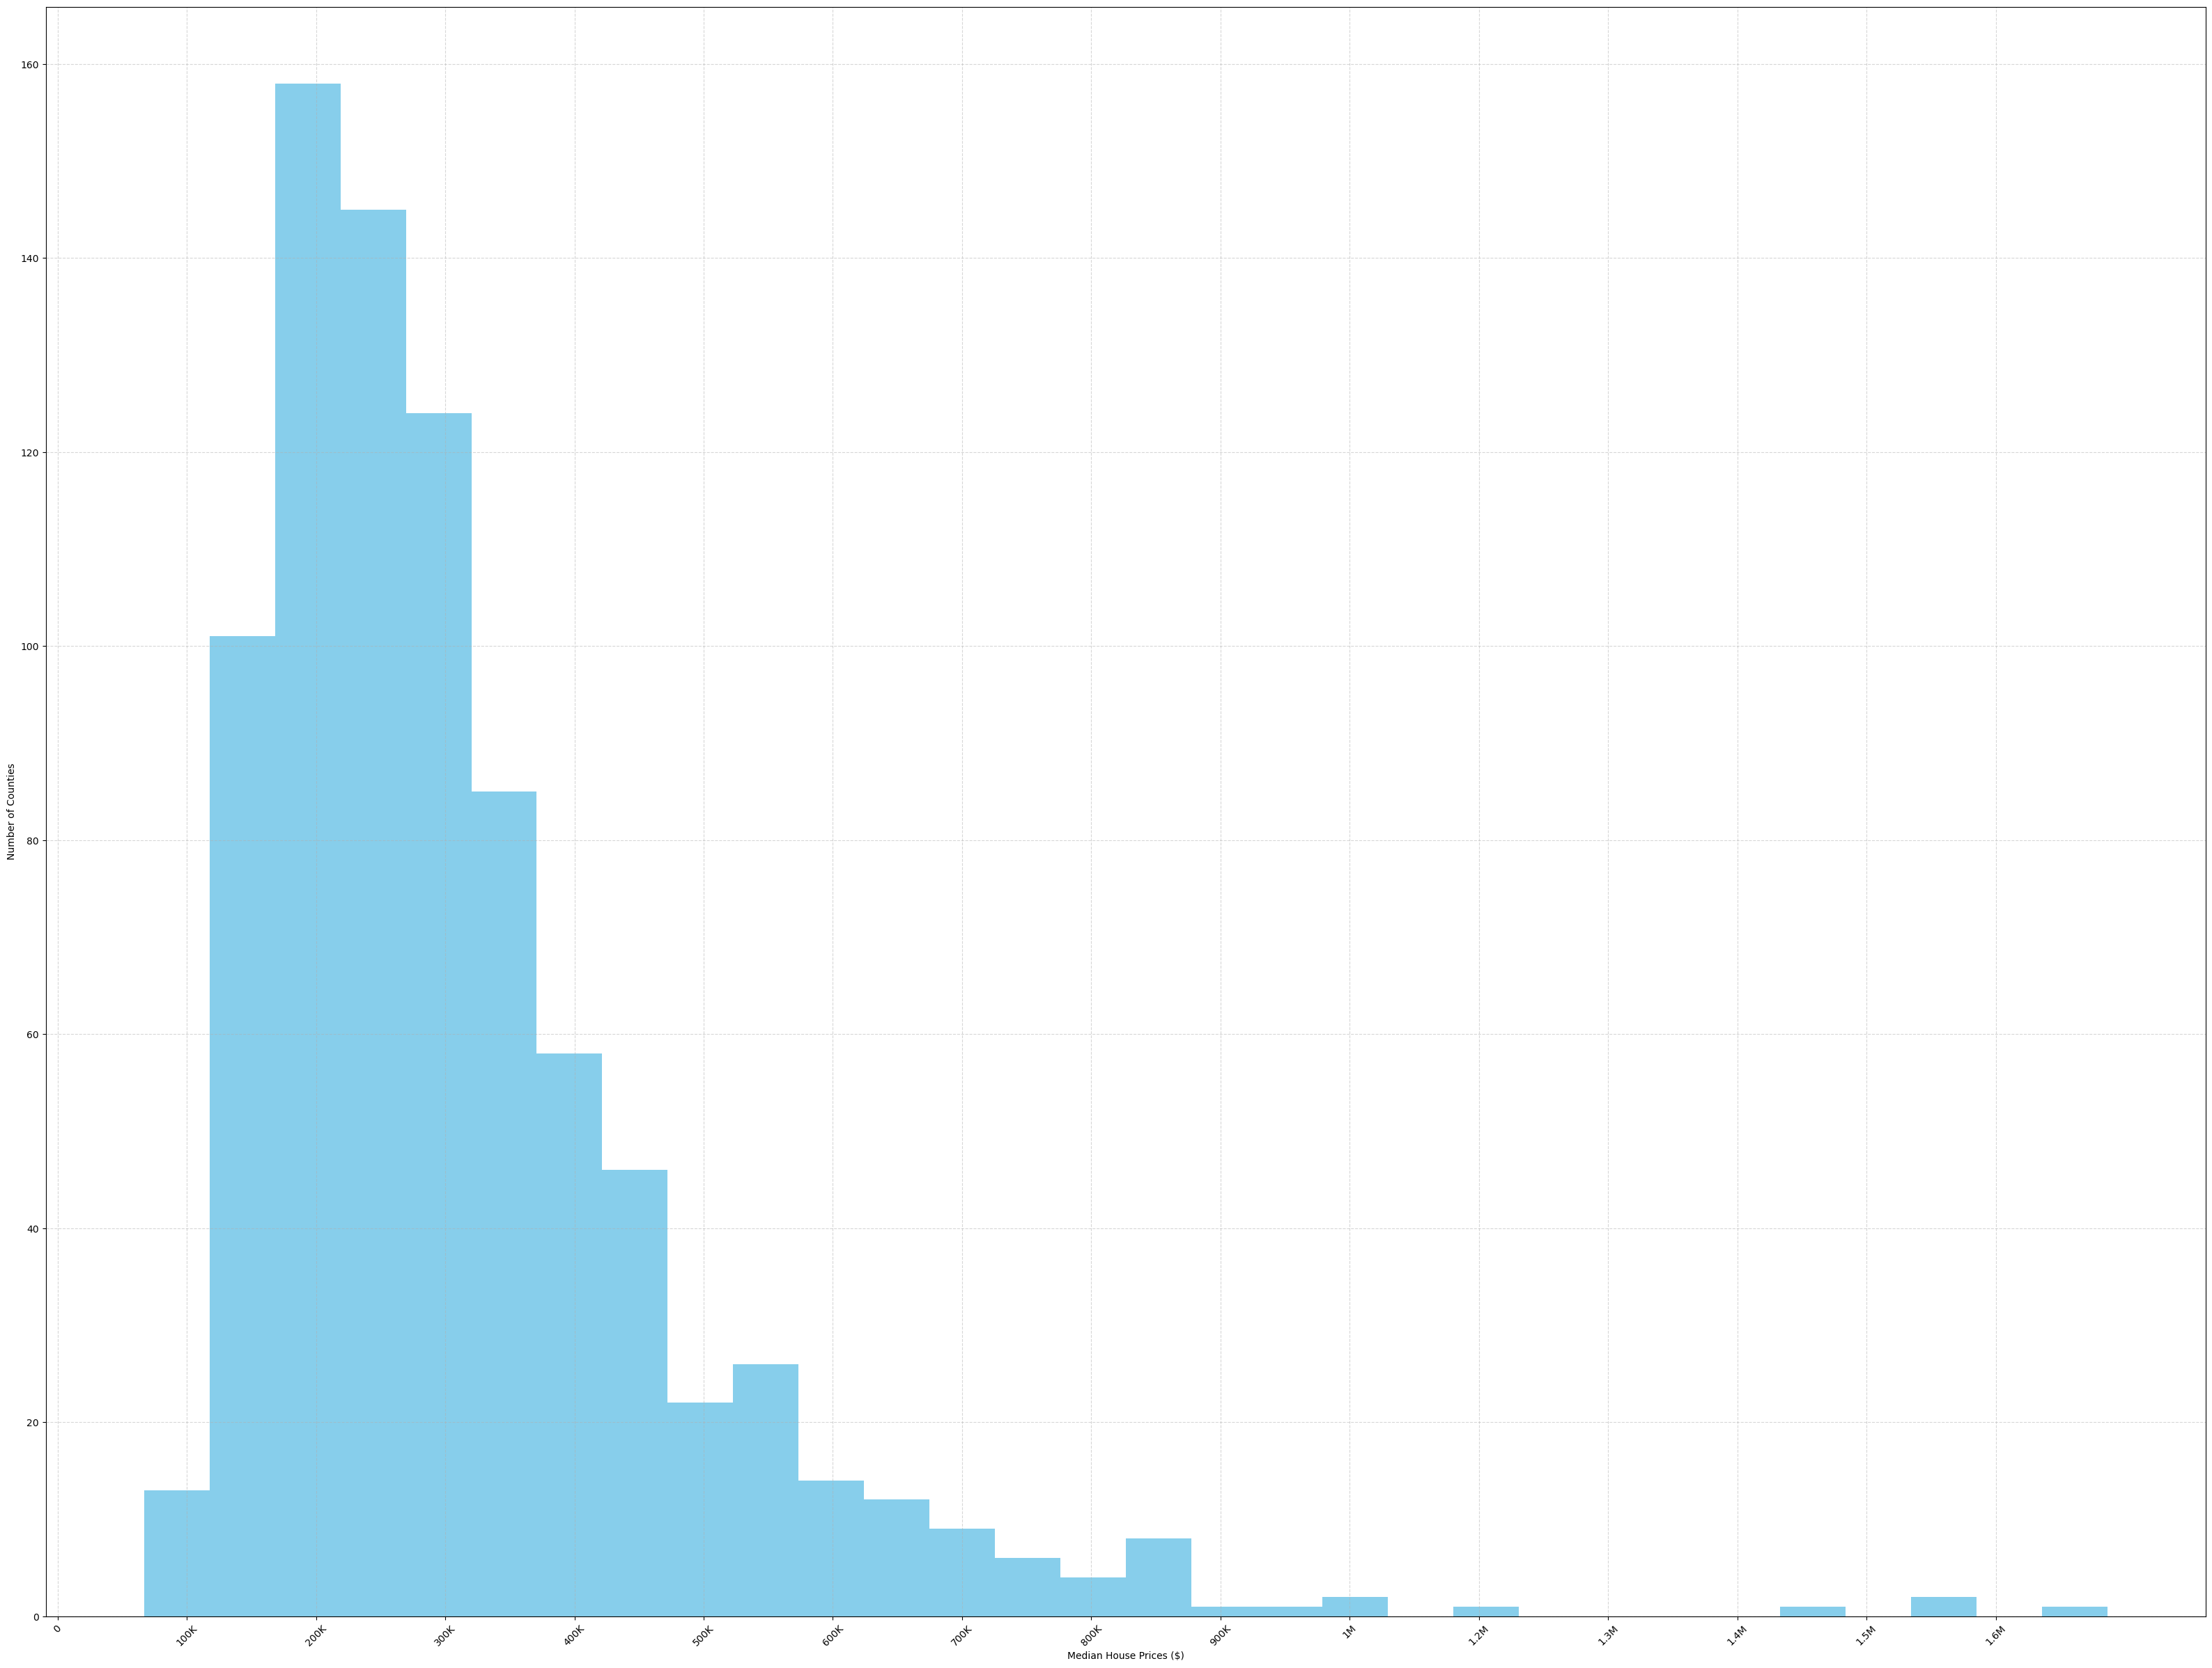

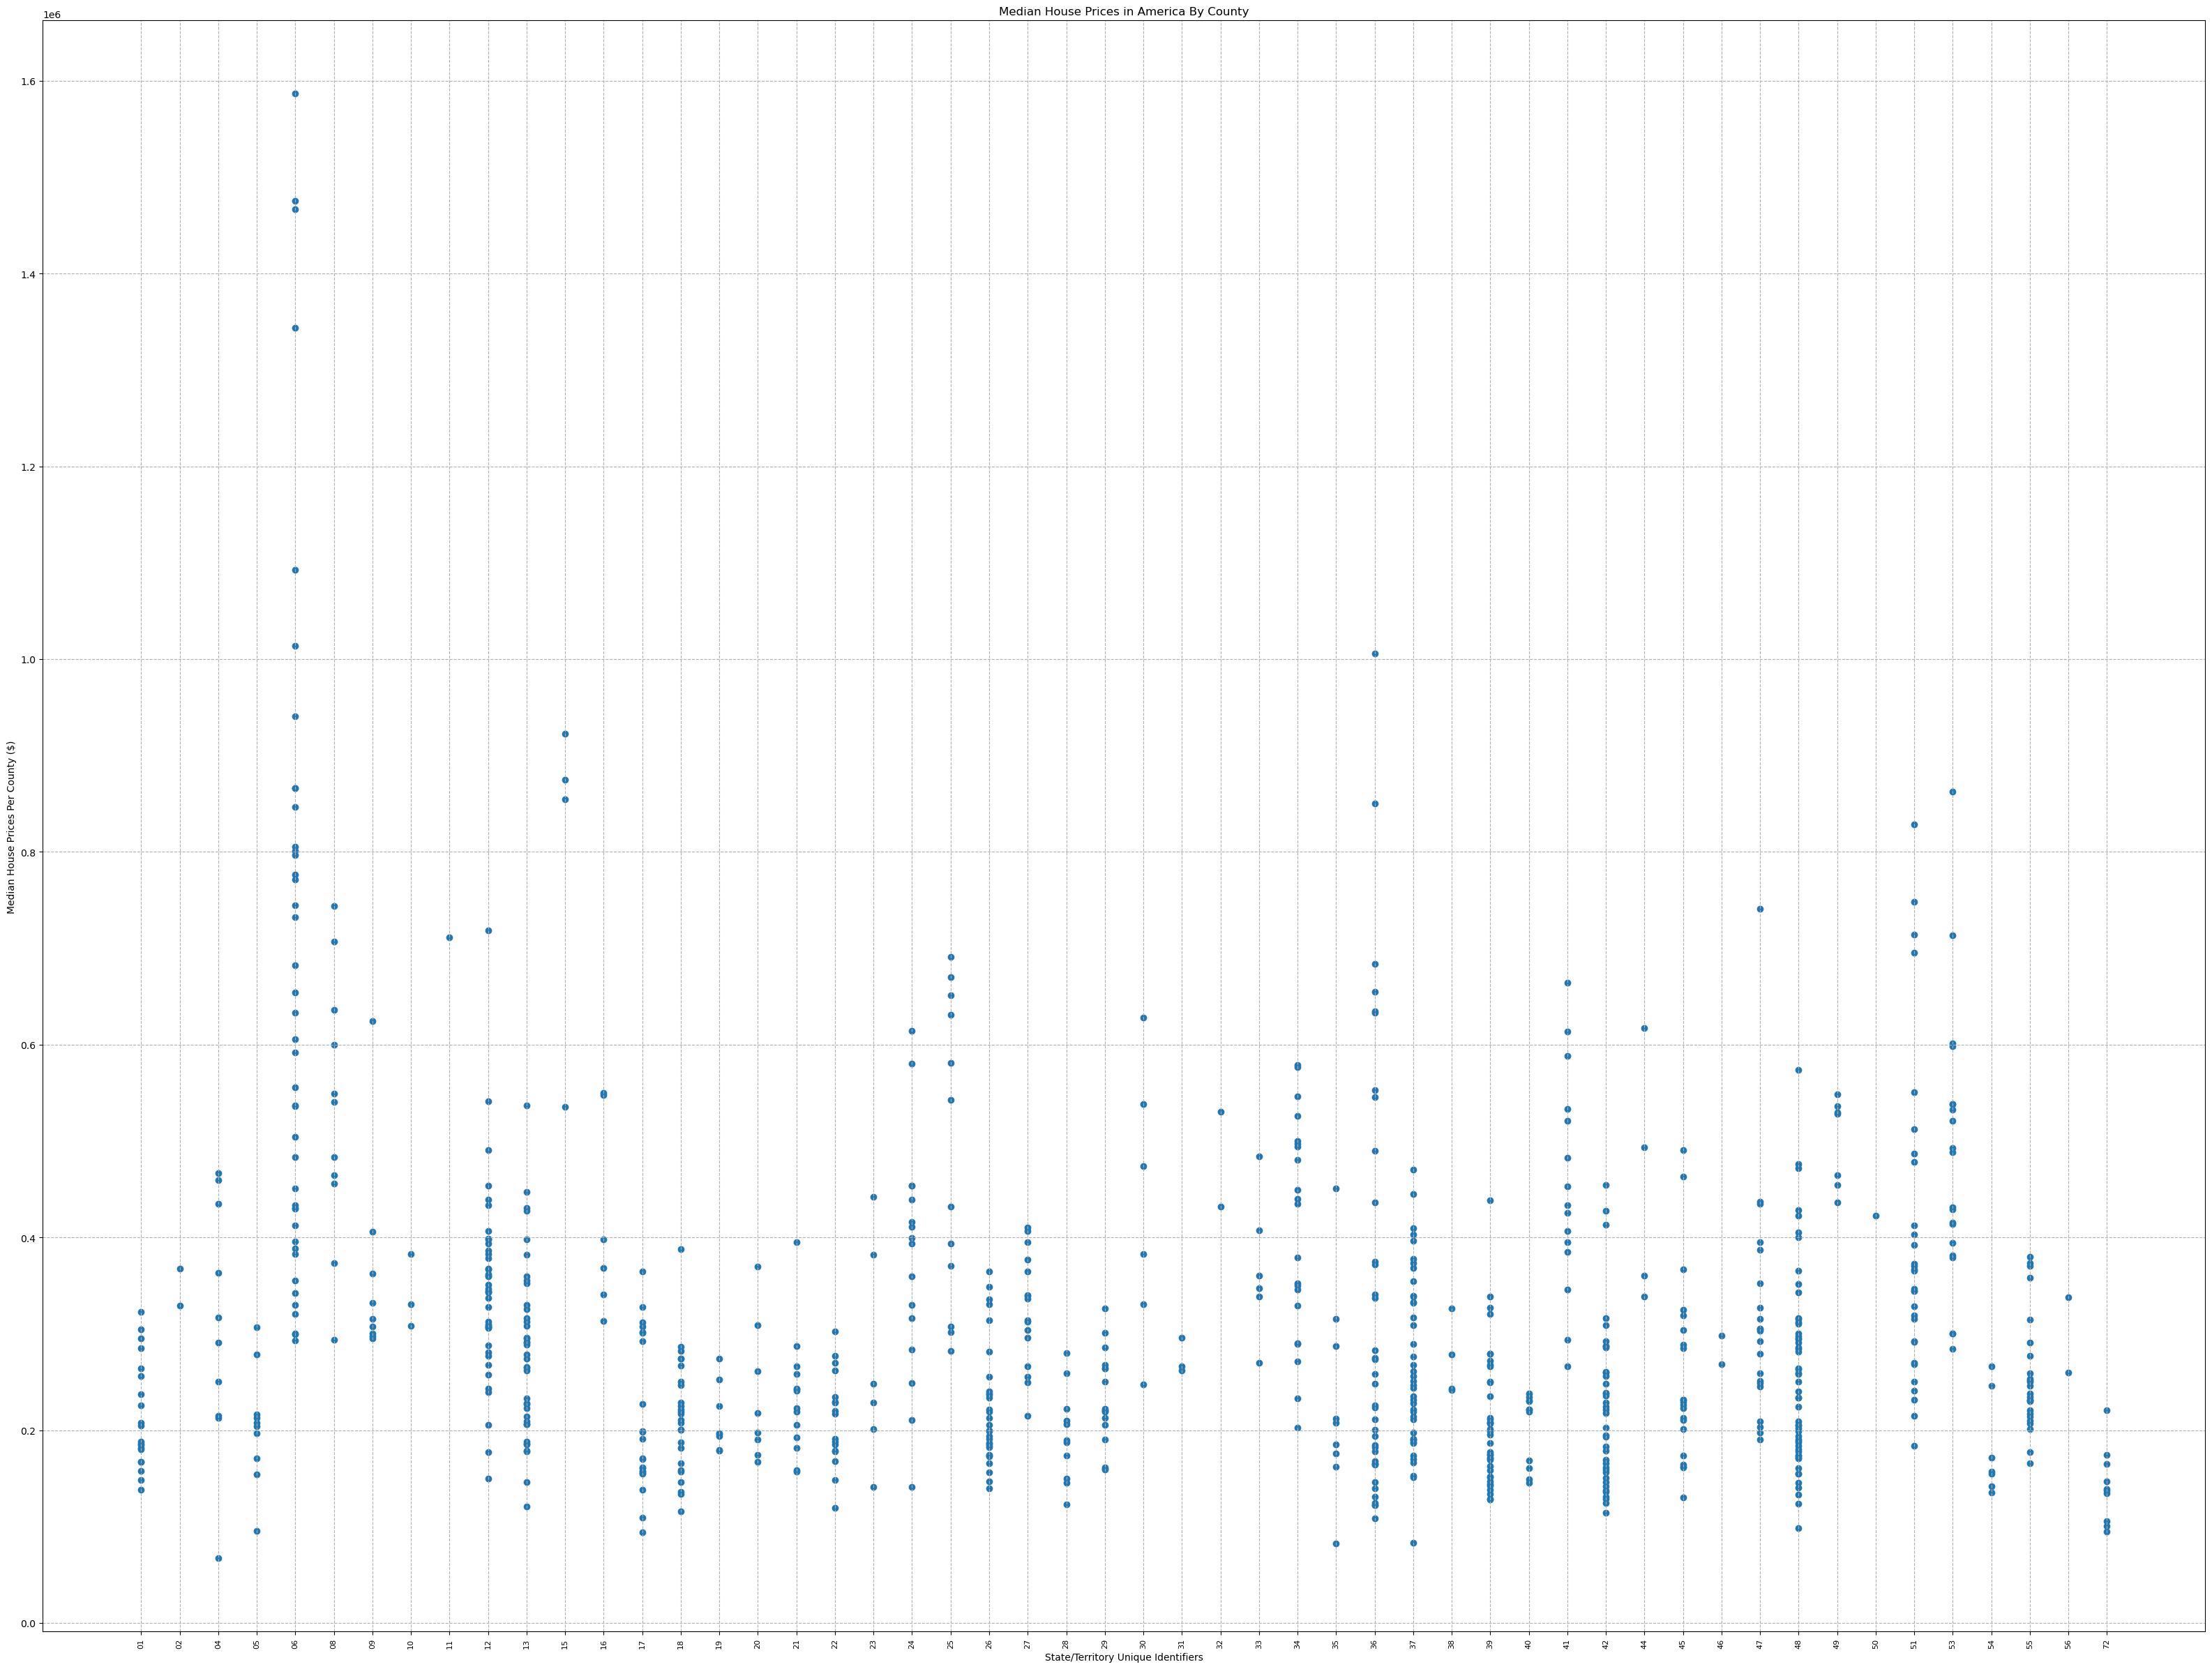

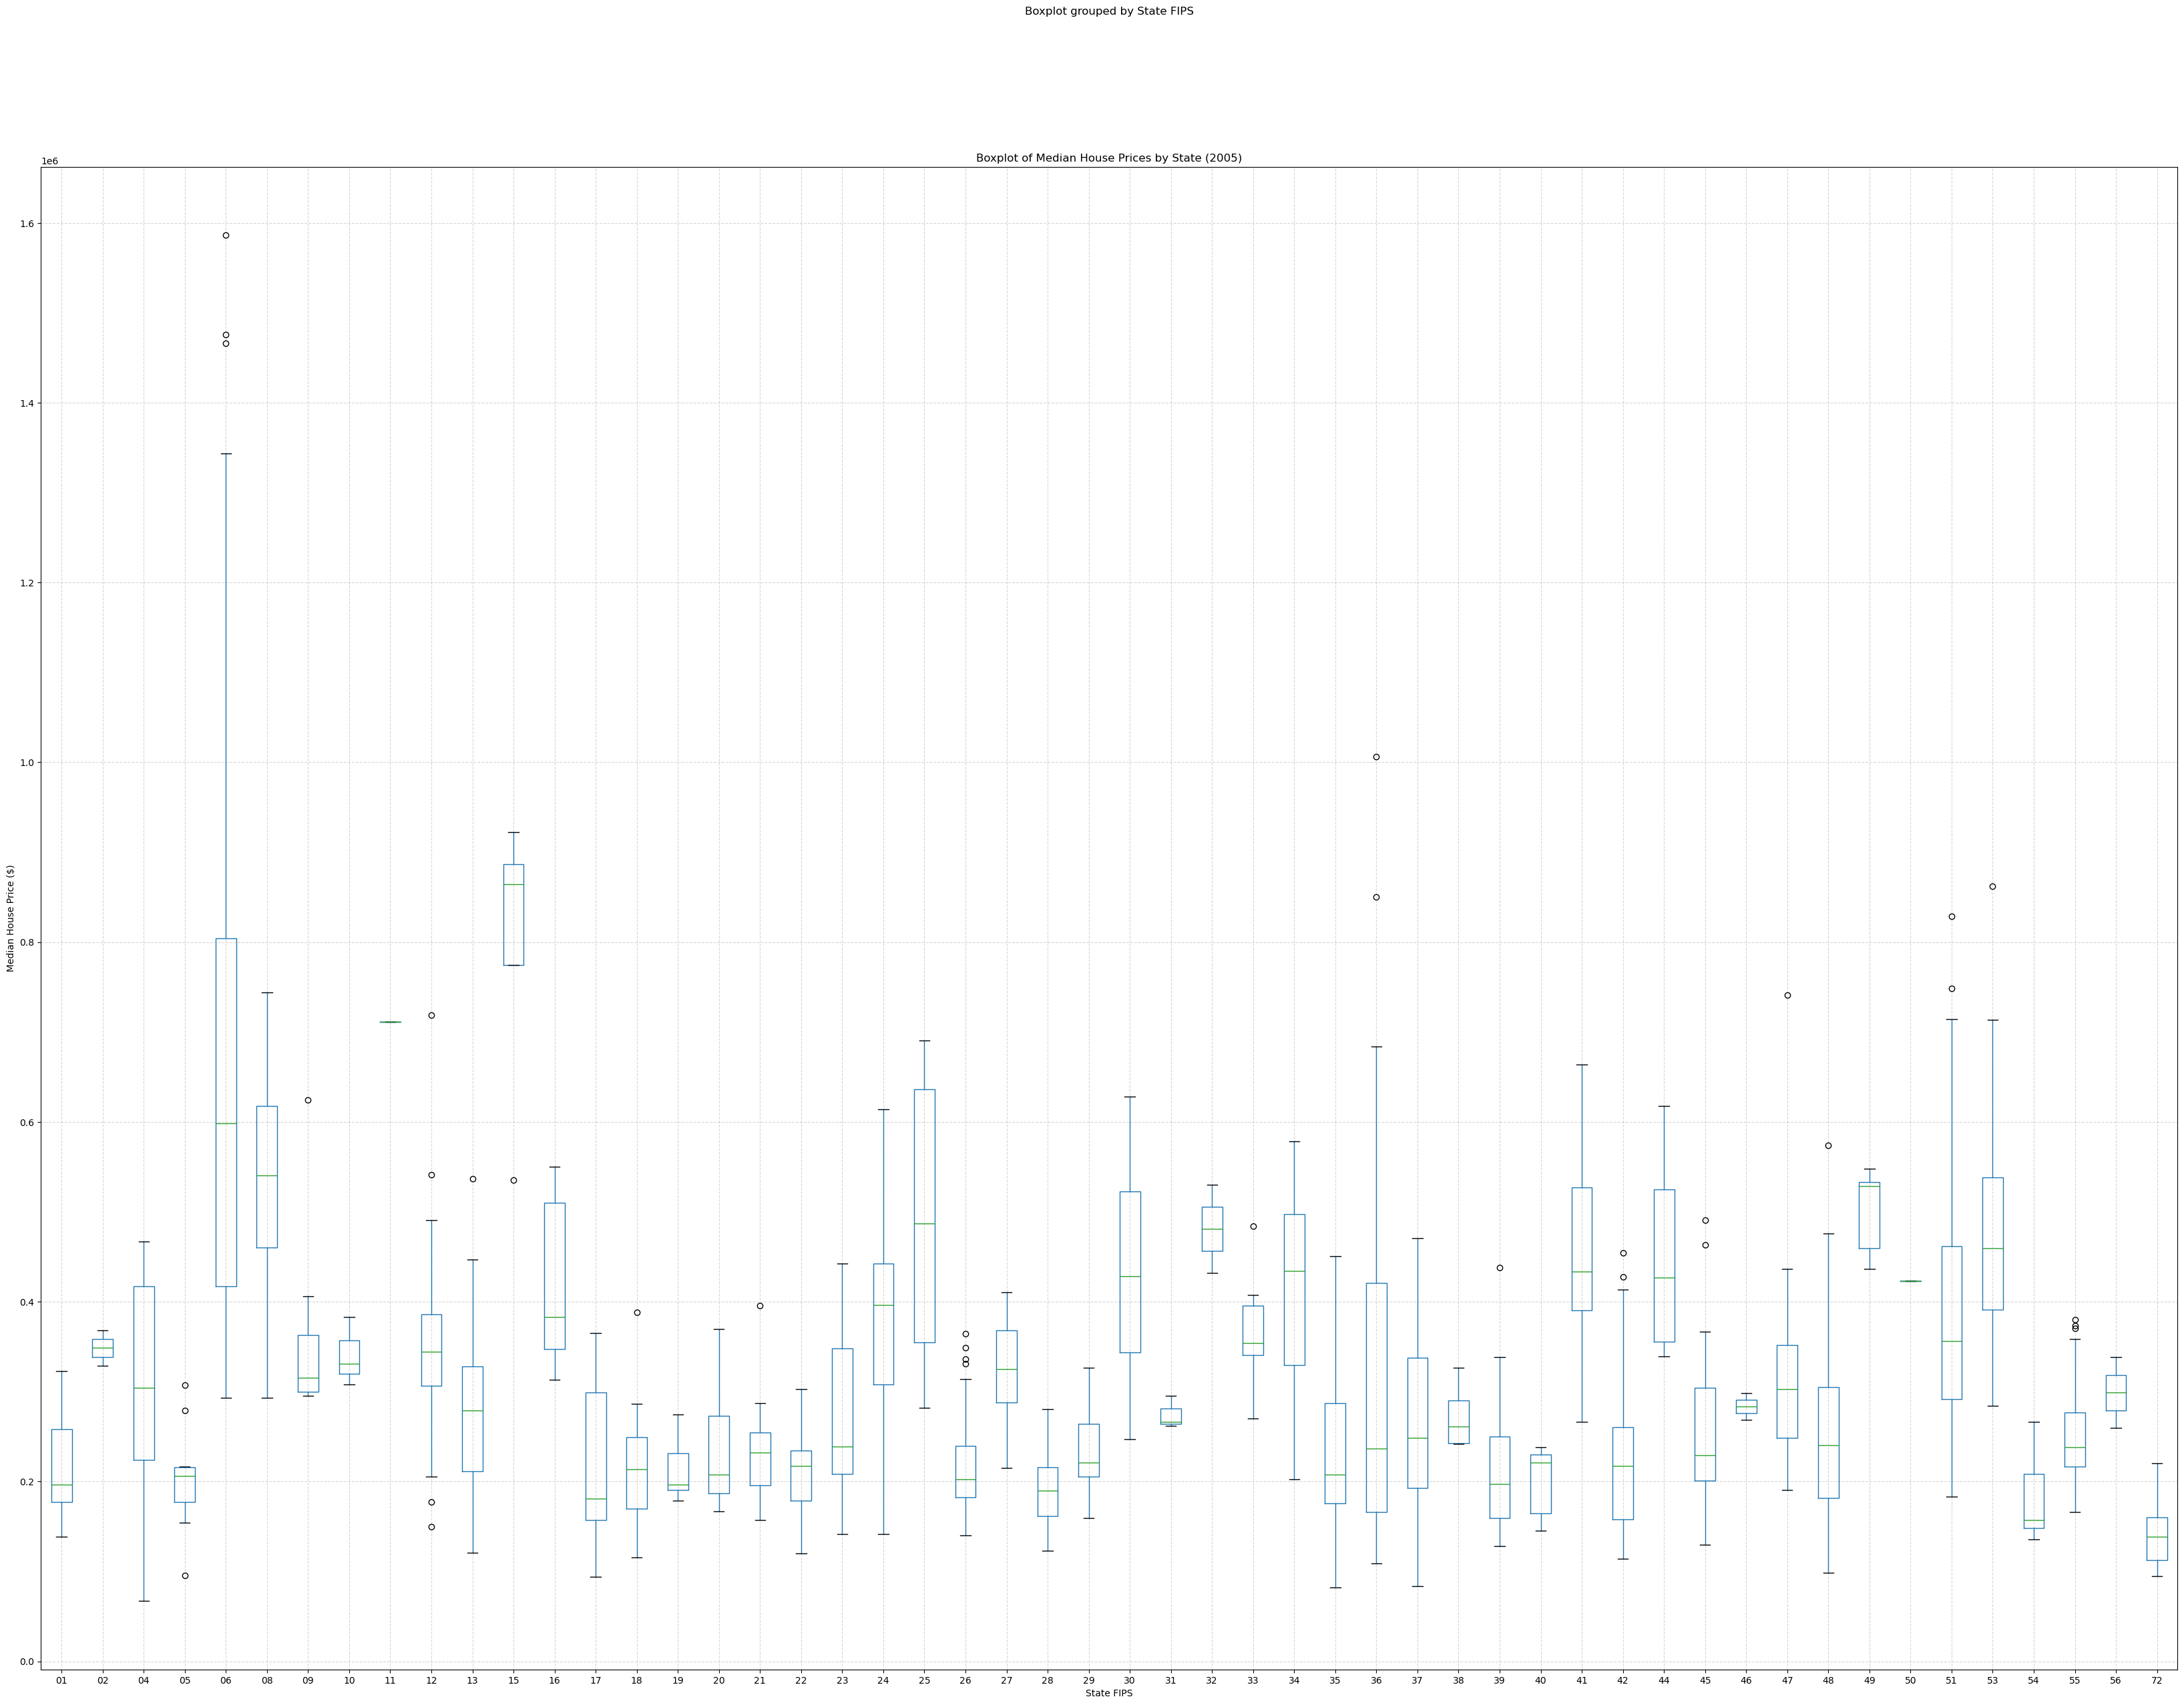

In [108]:
# Taking a look at house prices
#House Prices: Are the median prices increasing, decreasing, or remaining stable over time?
#Has the variability in house prices increased, indicating greater disparity?
#Are there any specific regions where house prices significantly outpace income growth?
#What is the impact of employment shocks on house prices?

plt.figure(figsize=(40,30))
first_year_data = clean_data_df.loc[data_df['Year'] == 2005]
x_values = np.arange(len(first_year_data))
plt.hist(first_year_data["Median House Price ($)"], bins=30, color='skyblue')
plt.xticks(ticks=range(0, 1600000, 100000), labels=['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M','1.2M', '1.3M', '1.4M', '1.5M', '1.6M'], rotation=45)
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


first_year_data = first_year_data.sort_values(by='State FIPS')
plt.figure(figsize=(40,30))
plt.scatter(first_year_data['State FIPS'], first_year_data['Median House Price ($)'])
plt.title('Median House Prices in America By County')
plt.ylabel('Median House Prices Per County ($)')
plt.xlabel('State/Territory Unique Identifiers')
plt.xticks(rotation=90, fontsize=8)
plt.grid(True, linestyle='--', alpha=1)
plt.show()


fig, ax = plt.subplots(figsize=(40, 30))  
first_year_data.boxplot(column='Median House Price ($)', by='State FIPS', grid=False, ax=ax)
ax.set_title('Boxplot of Median House Prices by State (2005)')
ax.set_xlabel('State FIPS')
ax.set_ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()




Plotting for mid-year - 2013

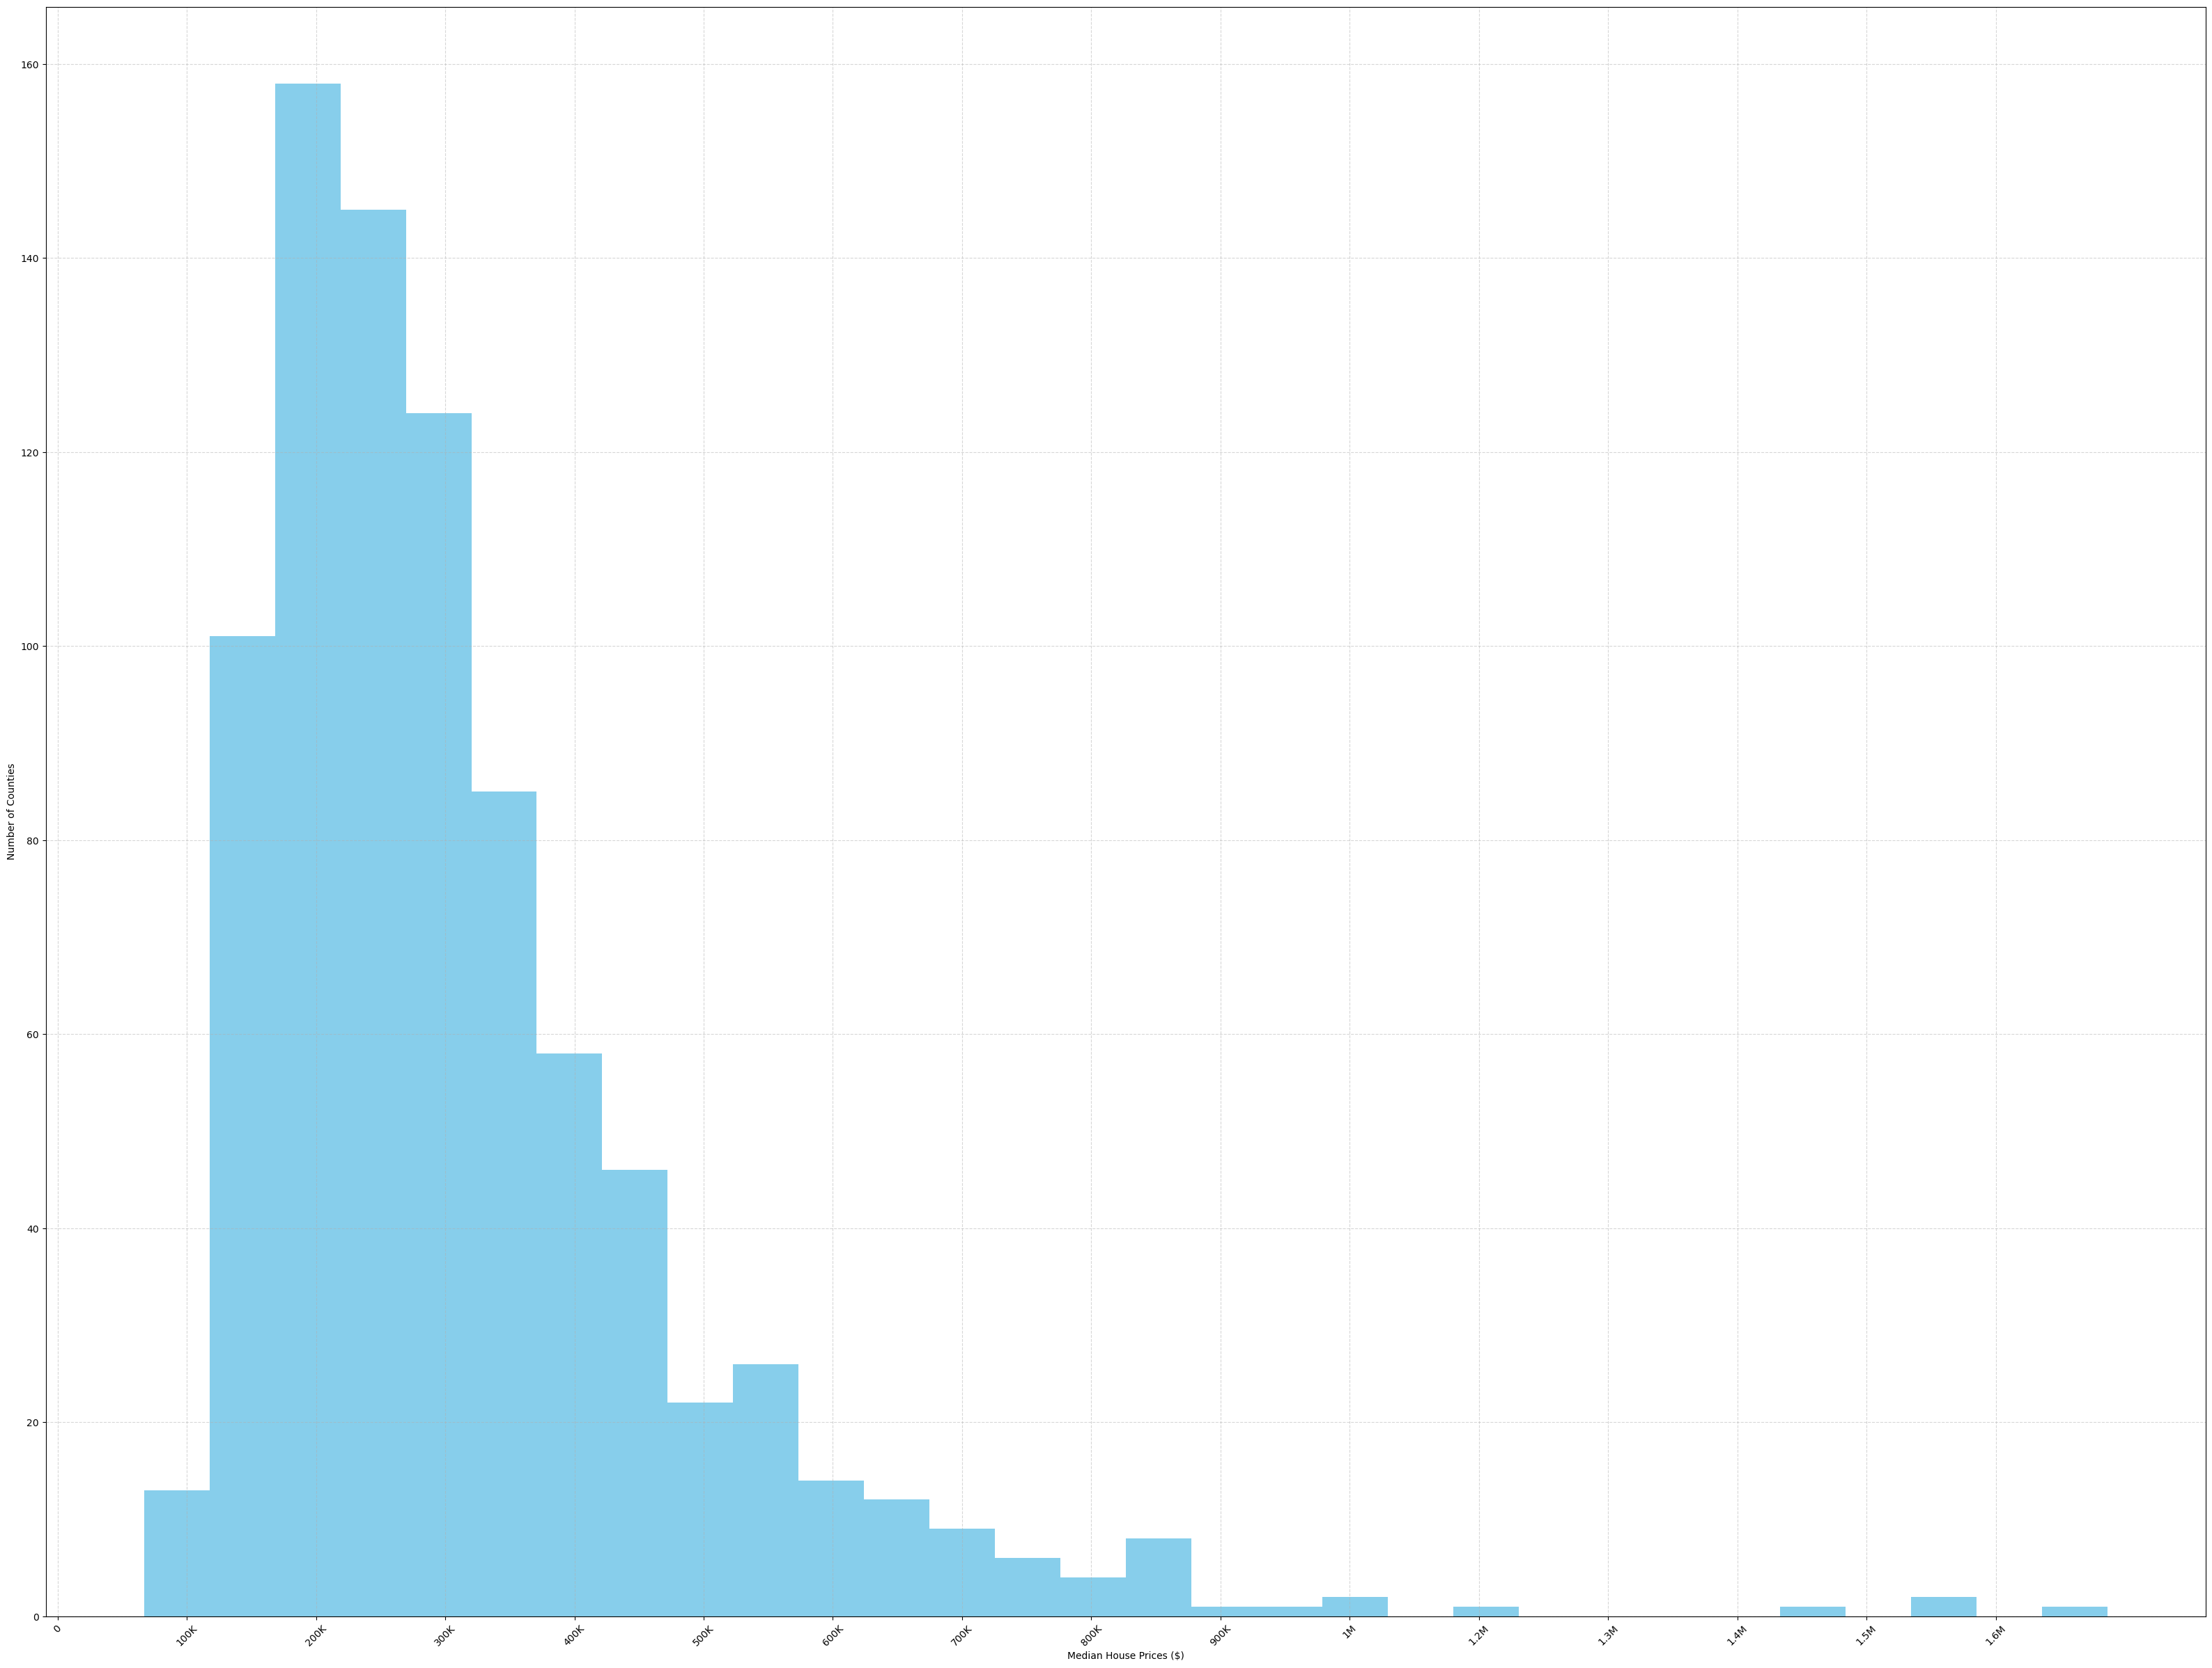

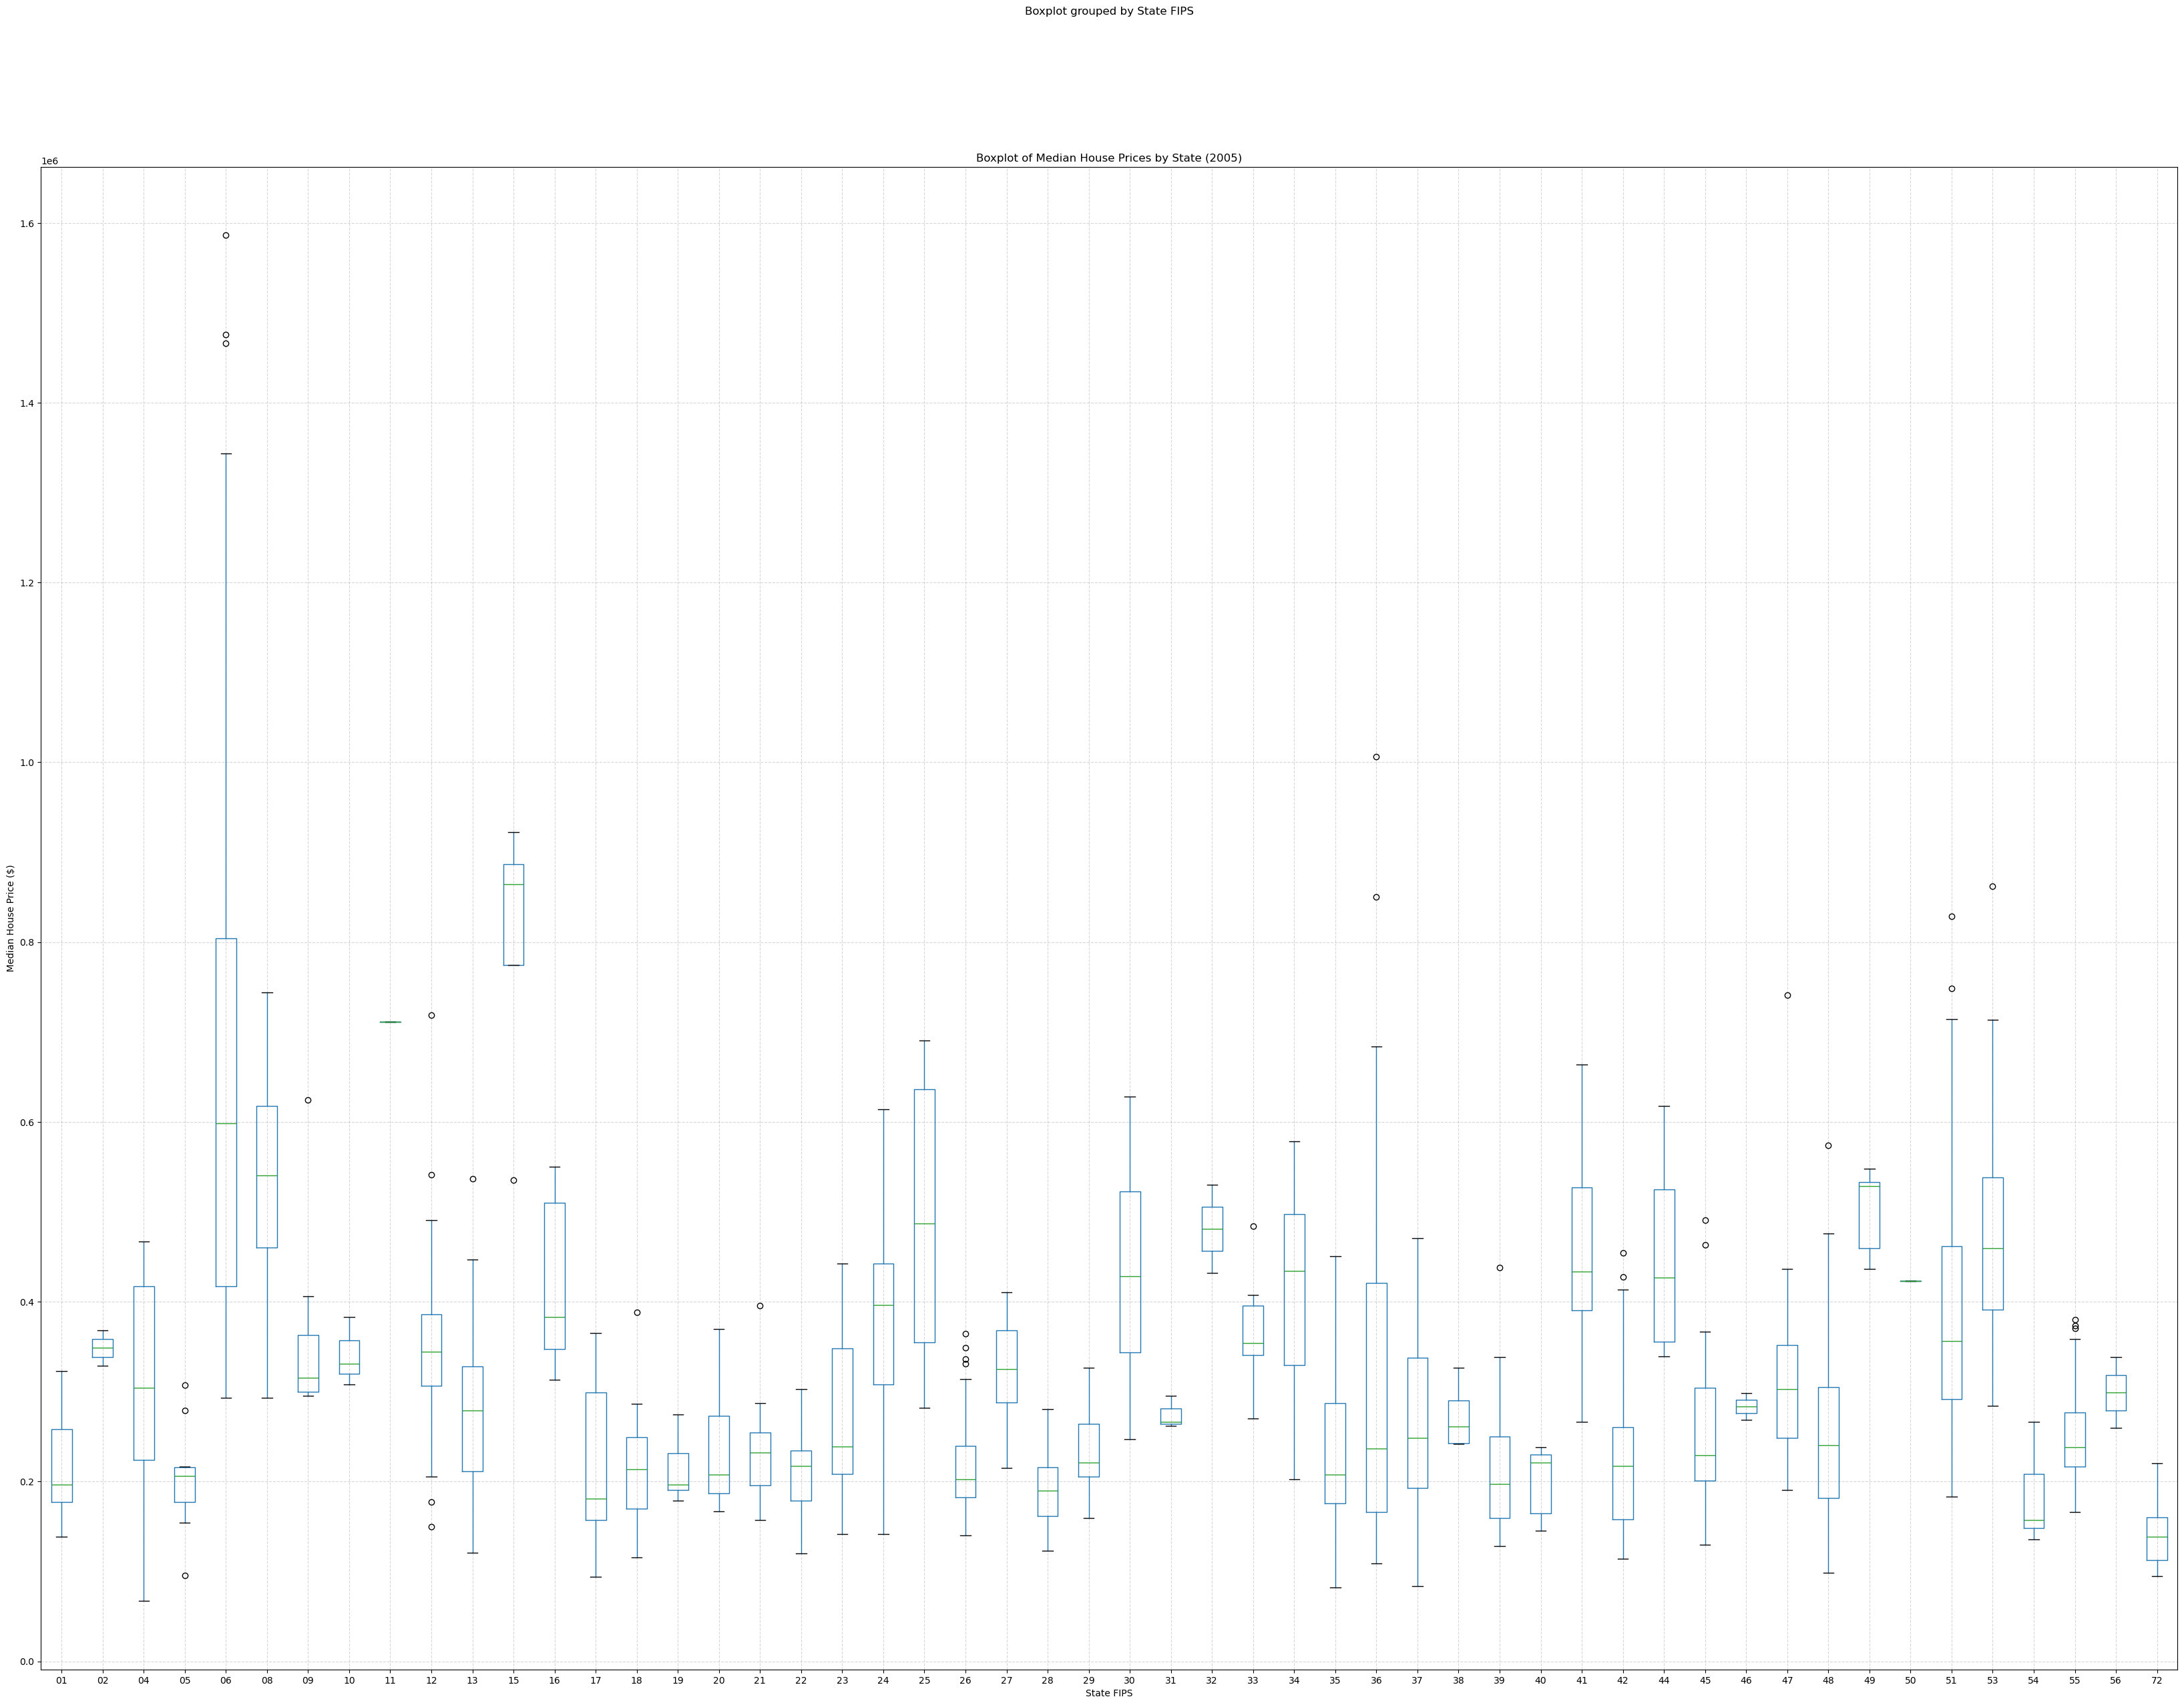

In [ ]:
plt.figure(figsize=(40,30))
mid_year_data = clean_data_df.loc[data_df['Year'] == 2013]
x_values = np.arange(len(mid_year_data))
plt.hist(mid_year_data["Median House Price ($)"], bins=30, color='skyblue')
plt.xticks(ticks=range(0, 1600000, 100000), labels=['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M','1.2M', '1.3M', '1.4M', '1.5M', '1.6M'], rotation=45)
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(40, 30))  
mid_year_data.boxplot(column='Median House Price ($)', by='State FIPS', grid=False, ax=ax)
ax.set_title('Boxplot of Median House Prices by State (2005)')
ax.set_xlabel('State FIPS')
ax.set_ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Final Year plots - 2022


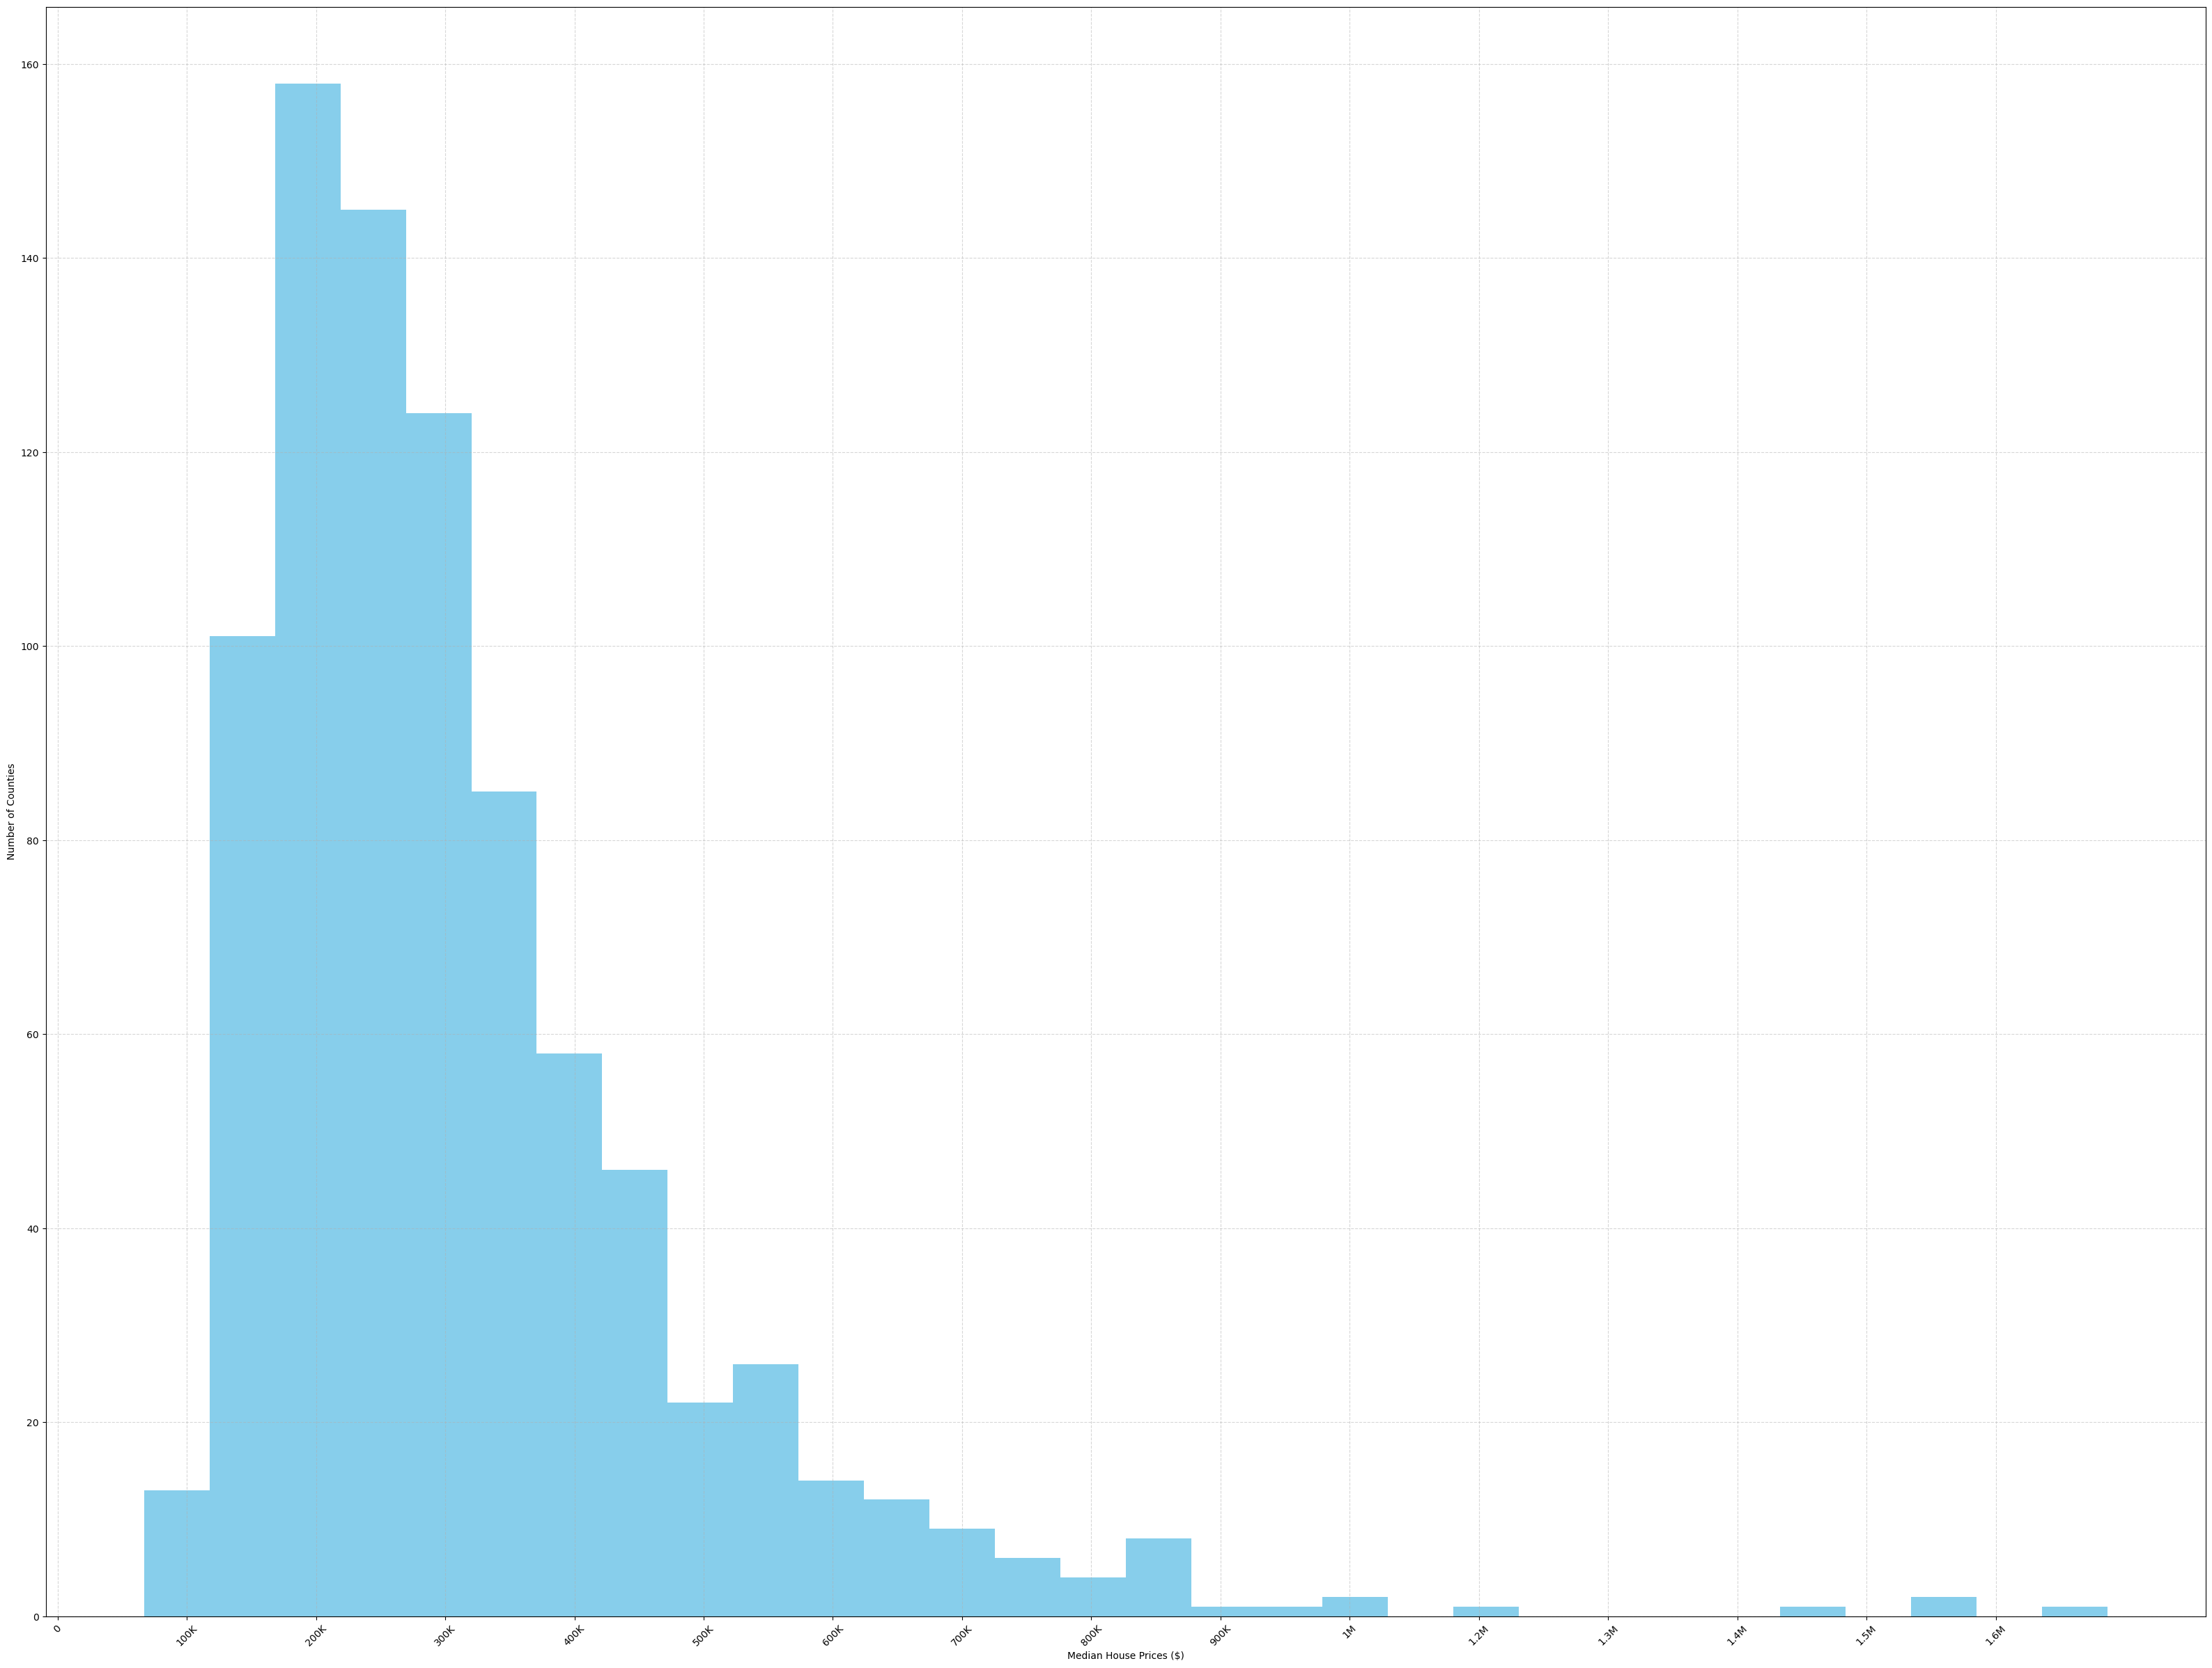

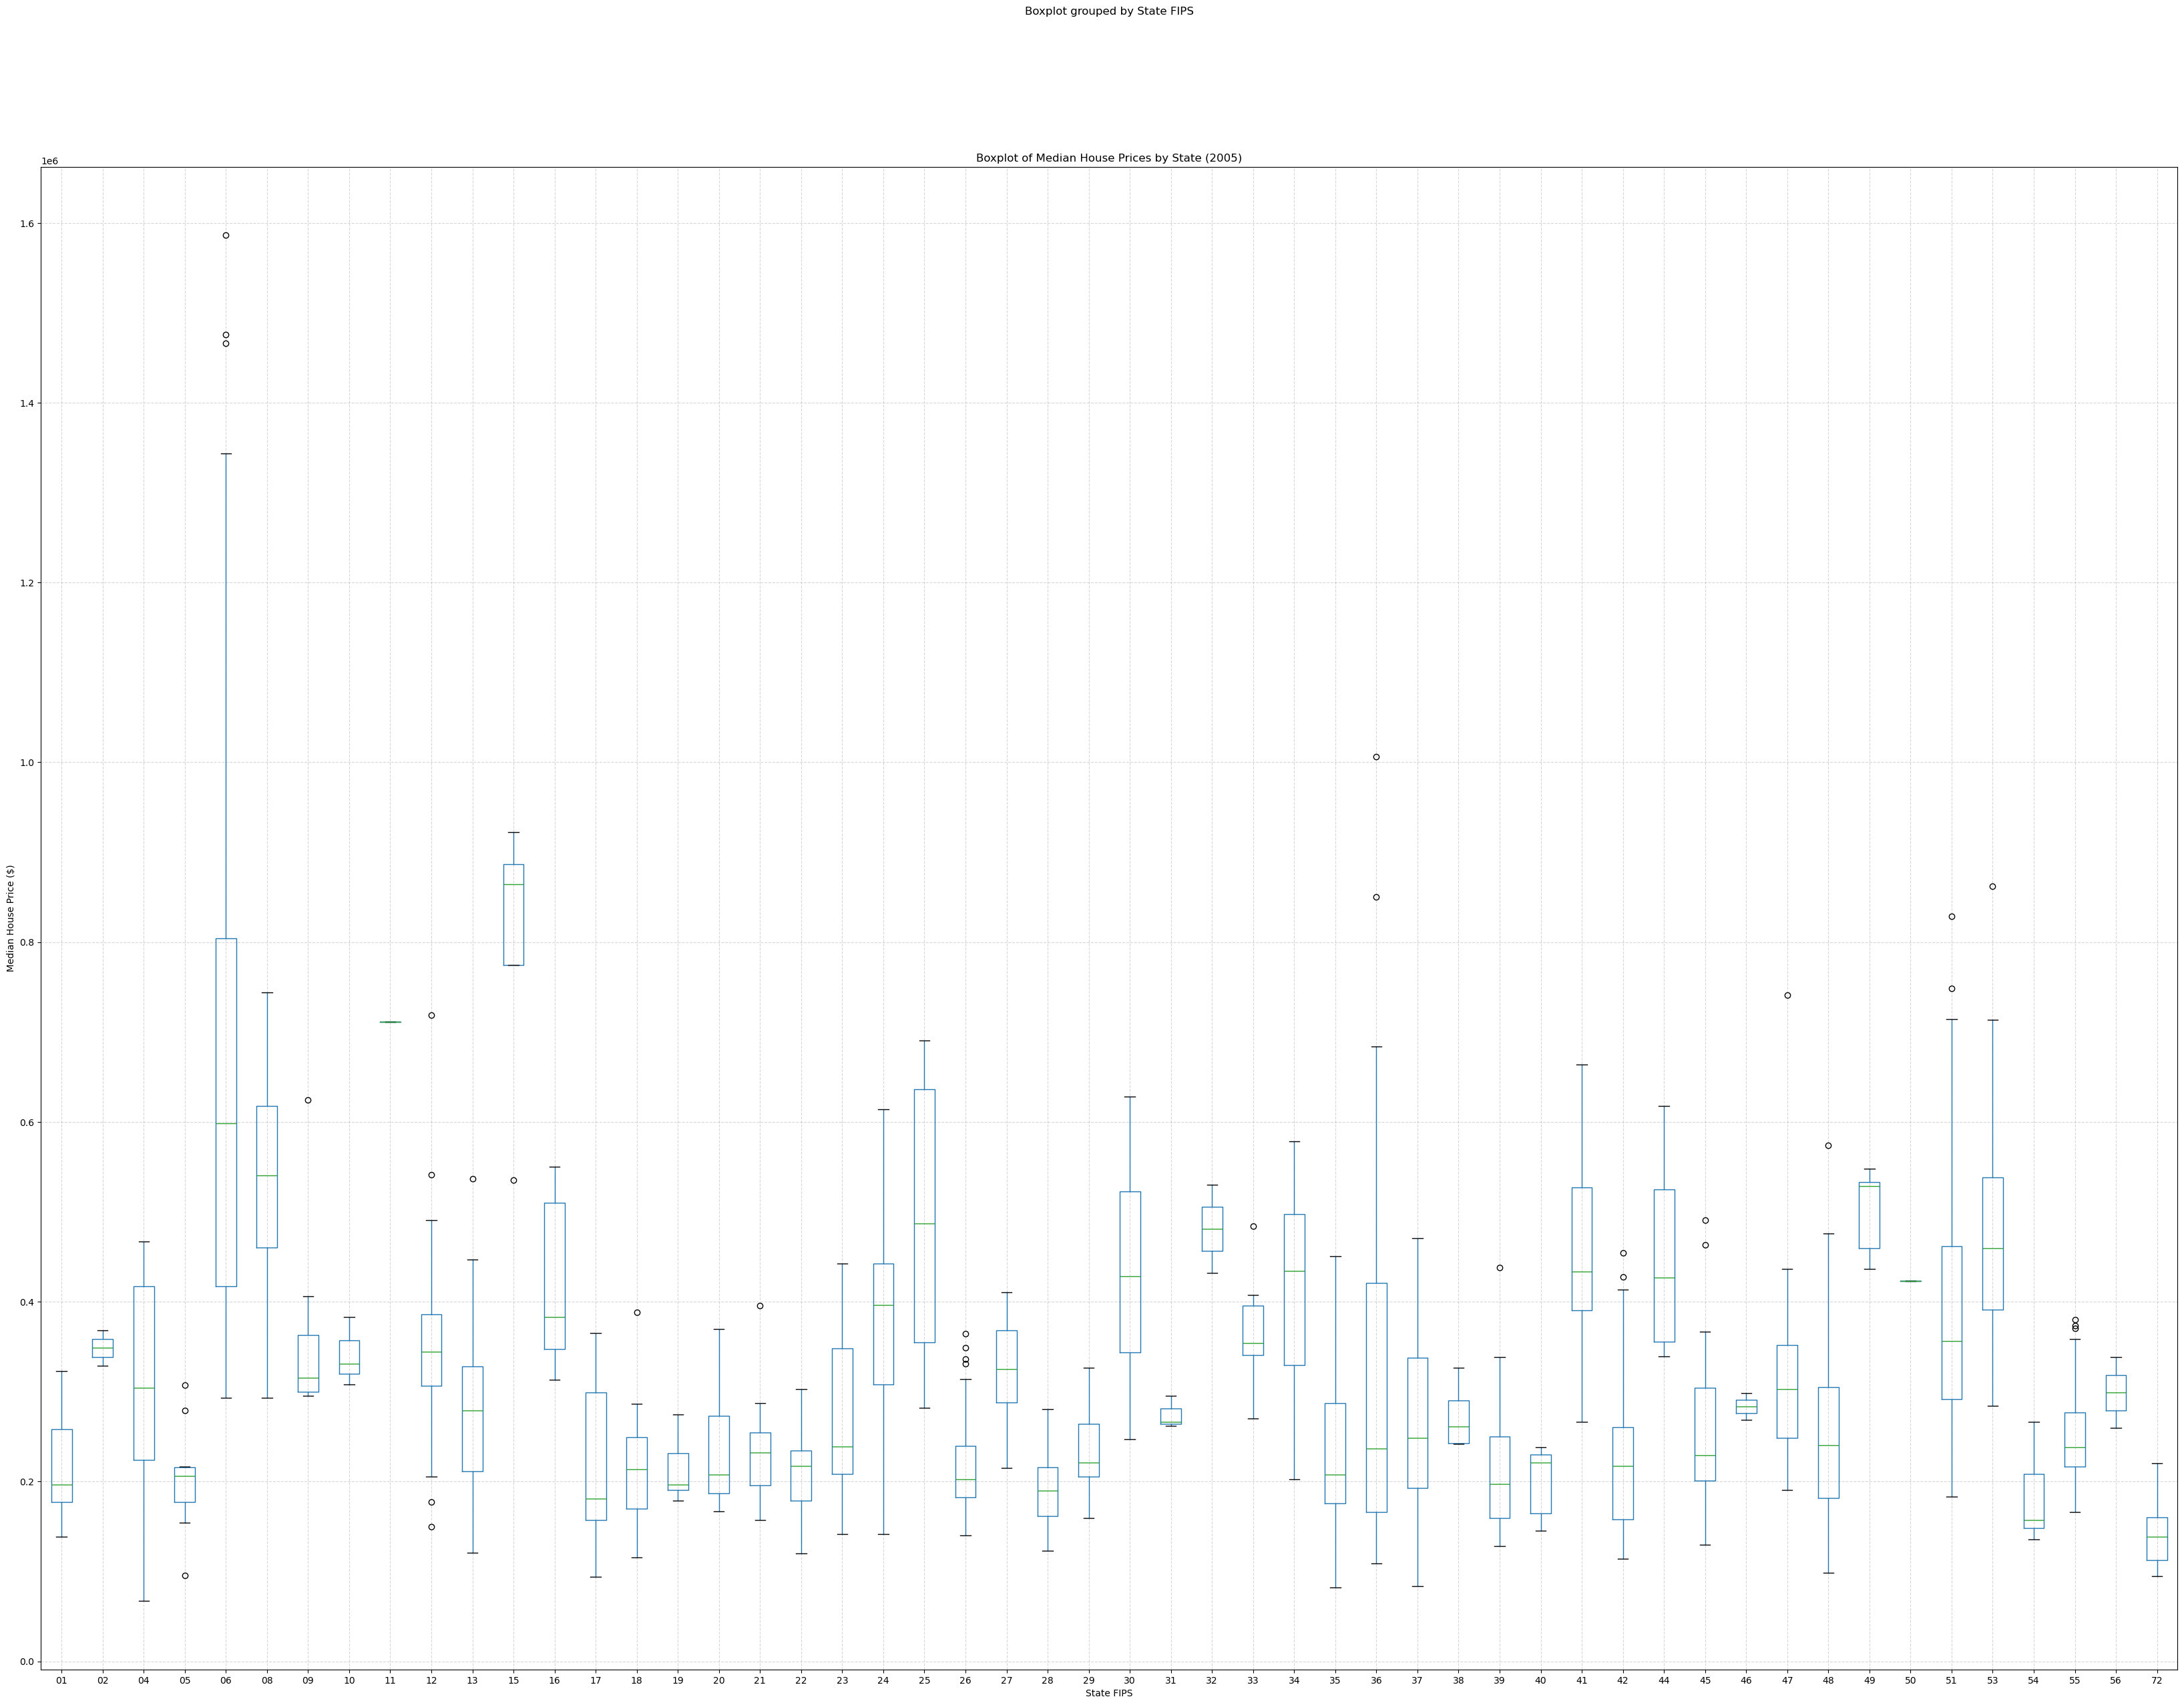

314089.1666666667


In [114]:
plt.figure(figsize=(40,30))
last_year_data = clean_data_df.loc[data_df['Year'] == 2013]
x_values = np.arange(len(last_year_data))
plt.hist(last_year_data["Median House Price ($)"], bins=30, color='skyblue')
plt.xticks(ticks=range(0, 1600000, 100000), labels=['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M','1.2M', '1.3M', '1.4M', '1.5M', '1.6M'], rotation=45)
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(40, 30))  
last_year_data.boxplot(column='Median House Price ($)', by='State FIPS', grid=False, ax=ax)
ax.set_title('Boxplot of Median House Prices by State (2005)')
ax.set_xlabel('State FIPS')
ax.set_ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(clean_data_df['Median House Price ($)'].mean())

Study how Home Prioes have changed over time
First Year - 2005
Central Tendency: Median House Prices tend to cluster around the $150-550k with the mean at $314K
Spread: Median House Prices Range from $40K to $1.6M, a wide range
Skewness: The distribution is skewed to the right (as a result of high home price observations at $800k+)
Outliers:
    - Visible outliers in the state of California, which has the highest home prices in the US, on average.
    - NY also has outliers, likely corresponding to Manhattan area housing
    - Arkansas and Puerto Rico have the lowest median house prices
    - We should compare to our variables here

Mid-year - 2013

Last Year - 2022

BRANCH 
variable histogram (instaces for % of population in poverty, for example)


Step 5 - DATA VISUALIZATION
#Scatter Plot:
Plot % Bachelor's Degree vs. Median House Price ($) to assess correlation visually. Add a regression line.
Time-Series Trends: Plot yearly trends of average house prices and educational attainment across counties.


Step 6: Hypothesis Testing
Correlation Test:
Test the significance of the correlation between % Bachelor's Degree and Median House Price ($) using Pearson or Spearman correlation:
python
from scipy.stats import pearsonr
corr, p_value = pearsonr(data_df['% Bachelors Degree'], data_df['Median House Price ($)'])
print(f"Correlation: {corr}, P-value: {p_value}")
Interpret results: 
𝑝 < 0.05
p<0.05 indicates significant correlation.

Regression Analysis:
Perform a linear regression to predict house prices using % Bachelor's Degree and other variables.
Interpret the p-value for % Bachelor's Degree to test its significance in predicting house prices.

Mean Comparison:
Compare house prices between counties with high vs. low educational attainment using a t-test:

python
Copy code
from scipy.stats import ttest_ind
high_edu = data_df[data_df['% Bachelors Degree'] > threshold]
low_edu = data_df[data_df['% Bachelors Degree'] <= threshold]
t_stat, p_value = ttest_ind(high_edu['Median House Price ($)'], low_edu['Median House Price ($)'])
print(f"T-test p-value: {p_value}")


STEP 7 - Insights & Reporting
Summarize findings, focusing on:
Strength and direction of correlation.
Patterns over time and across counties.
Results of hypothesis tests.
Highlight key takeaways:
Are counties with higher educational attainment significantly correlated with higher house prices?
Are there outliers or regions where the relationship deviates?
Discuss limitations (e.g., potential confounding variables or data coverage).